In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer
import ipyparallel as ipp
from scipy.stats import linregress
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import json
from pyproj import Transformer
from sklearn.decomposition import PCA

In [2]:
s3_sar_5021 = "https://ds-h-ca-bigdata.s3.us-east-2.amazonaws.com/CA_DWR_VERT.csv"
sar_5021 = pd.read_csv(s3_sar_5021)

In [3]:
dry = ["2017", "2019", "2020", "2021"]
wet = ["2015", "2016", "2018", "2022", "2023"] # all in water year beginning Oct --> Sep

In [4]:
sar_5021.head()

CODE        LAT         LON     HEIGHT  VEL_V  D20150101  D20150107  \
0  DX5IPRM  40.338973 -122.018572  320.85570   -1.6        NaN        NaN   
1  DX5IPRN  40.338973 -122.017438  673.82640   -0.6        NaN        NaN   
2  DX5IPRO  40.338973 -122.016305   10.95188   -0.3        NaN        NaN   
3  DX5IPRP  40.338973 -122.015171  140.33210   -1.1        NaN        NaN   
4  DX5IPRQ  40.338973 -122.014037   25.95095   -0.1        NaN        NaN   

   D20150113  D20150120  D20150126  ...  D20240813  D20240820  D20240826  \
0        NaN        NaN        NaN  ...       -0.6        1.2        3.1   
1        NaN        NaN        NaN  ...       -1.8       -1.5       -1.3   
2        NaN        NaN        NaN  ...        1.2        1.2        1.5   
3        NaN        NaN        NaN  ...       -0.0        0.3        1.0   
4        NaN        NaN        NaN  ...        3.3        3.7        4.5   

   D20240901  D20240907  D20240913  D20240919  D20240925  D20241001  \
0        3.7        3.6        4.9        6.3        5.2        3.4   
1       -1.2       -1.0       -0.3       -0.2       -0.2       -0.4   
2        2.0        2.1        2.5        2.5        2.6        2.0   
3        1.8        2.1        2.8        3.0        2.9        2.1   
4        5.3        5.3        5.6        5.6        5.4        4.5   

   Basin_Subb  
0    5-021.53  
1    5-021.53  
2    5-021.53  
3    5-021.53  
4    5-021.53  

[5 rows x 592 columns]

In [5]:
def is_oct_2015_or_later(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        try:
            date_str = col_name[1:]
            date = datetime.strptime(date_str, '%Y%m%d')
            return date >= datetime(2015, 10, 1)
        except ValueError:
            return False
    return True

In [6]:
wy_2015_or_later = [col for col in sar_5021.columns if is_oct_2015_or_later(col)]

In [7]:
sar_5021_2015 = sar_5021[wy_2015_or_later].copy()

In [8]:
def extract_year_month(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        try:
            date_str = col_name[1:]
            date = datetime.strptime(date_str, '%Y%m%d')
            return date.year, date.month
        except ValueError:
            pass
    return None, None

year_month_columns = {}
for col in sar_5021_2015.columns:
    year, month = extract_year_month(col)
    if year is not None:
        year_month_columns.setdefault((year, month), []).append(col)

def calculate_average(row, columns):
    valid_values = [row[col] for col in columns if not pd.isna(row[col])]
    return np.mean(valid_values) if valid_values else np.nan

results = []
for index, row in tqdm(sar_5021_2015.iterrows(), total=len(sar_5021_2015), desc="Processing rows"):
    row_results = {'CODE': row['CODE']}
    for (year, month), columns in year_month_columns.items():
        if month == 10:
            oct_avg = calculate_average(row, columns)
            next_year_sep_columns = year_month_columns.get((year + 1, 9), [])
            sep_avg = calculate_average(row, next_year_sep_columns)
            if not np.isnan(oct_avg) and not np.isnan(sep_avg):
                row_results[f'Diff_{year}'] = oct_avg - sep_avg
    results.append(row_results)

wy_sar_5021 = pd.DataFrame(results)

Processing rows: 100%|██████████| 707344/707344 [07:12<00:00, 1636.31it/s]


In [9]:
def extract_year(col_name):
    if col_name.startswith('D') and len(col_name) == 9:
        return col_name.split("_")[1]
    return None

dry_columns = [col for col in wy_sar_5021.columns if extract_year(col) in dry]
wet_columns = [col for col in wy_sar_5021.columns if extract_year(col) in wet]

print("Dry Year Columns:", dry_columns)
print("Wet Year Columns:", wet_columns)

results = []
for idx, row in tqdm(wy_sar_5021.iterrows(), total=len(wy_sar_5021), desc="Processing rows"):
    well_code = row['CODE']
    dry_avg = row[dry_columns].mean()
    wet_avg = row[wet_columns].mean()
    results.append({
        'CODE': well_code,
        'Dry_Year_Avg': dry_avg,
        'Wet_Year_Avg': wet_avg
    })

wy_sar_5021_dry_wet = pd.DataFrame(results)

Dry Year Columns: ['Diff_2017', 'Diff_2020', 'Diff_2021', 'Diff_2019']
Wet Year Columns: ['Diff_2015', 'Diff_2016', 'Diff_2018', 'Diff_2022', 'Diff_2023']


Processing rows: 100%|██████████| 707344/707344 [08:00<00:00, 1472.57it/s]


In [10]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

In [11]:
wy_sar_5021_dry_wet.head()

CODE  Dry_Year_Avg  Wet_Year_Avg
0  DX5IPRM      0.283333         2.226
1  DX5IPRN     -1.985000         3.196
2  DX5IPRO     -2.105000         2.860
3  DX5IPRP     -1.195000         3.244
4  DX5IPRQ     -2.605000         3.740

In [12]:
wy_sar_5021_dry_wet = pd.merge(wy_sar_5021_dry_wet, sar_5021[["CODE", "LAT", "LON"]], on="CODE", how='left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


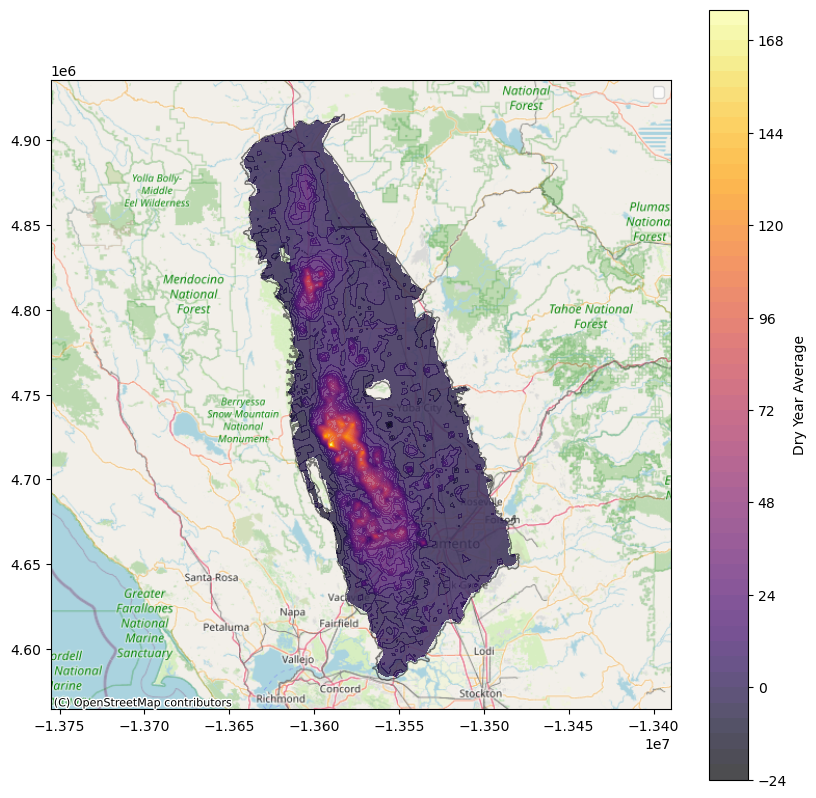

In [13]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']

larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    wy_sar_5021_dry_wet,
    geometry=gpd.points_from_xy(wy_sar_5021_dry_wet['LON'], wy_sar_5021_dry_wet['LAT']),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x.values
y = wells_gdf.geometry.y.values
z = wells_gdf['Dry_Year_Avg'].values

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)
xx, yy = np.meshgrid(grid_x, grid_y)

def idw_interpolation(x, y, z, grid_x, grid_y, power=2):
    grid_z = np.empty((len(grid_y), len(grid_x)))
    k = 100
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            d = np.sqrt((x - xi)**2 + (y - yi)**2)
            valid = ~np.isnan(z)
            if not np.any(valid):
                grid_z[j, i] = np.nan
                continue

            d_valid = d[valid]
            z_valid = z[valid]

            k_actual = min(k, len(d_valid))
            idx_sorted = np.argsort(d_valid)[:k_actual]
            d_nearest = d_valid[idx_sorted]
            z_nearest = z_valid[idx_sorted]

            if np.any(d_nearest == 0):
                grid_z[j, i] = z_nearest[d_nearest == 0][0]
            else:
                weights = 1 / d_nearest**power
                grid_z[j, i] = np.sum(weights * z_nearest) / np.sum(weights)
    return grid_z

z_interp = idw_interpolation(x, y, z, grid_x, grid_y, power=2)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)

mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked = np.ma.masked_where(~mask, z_interp)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10))
larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=50, 
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

ax.legend()
ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.OpenStreetMap.Mapnik
)

plt.show()

In [13]:
def fetch_counts_for_year(year):
    counts_for_year = defaultdict(int)
    offset = 0
    limit = 10000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts_for_year[site_code] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break
    return counts_for_year

rc = ipp.Client()
dview = rc[:]

with dview.sync_imports():
    import requests
    from collections import defaultdict

dview.push({'fetch_counts_for_year': fetch_counts_for_year})

years = list(range(2008, 2025))

async_results = dview.map_async(fetch_counts_for_year, years)
results = async_results.get()

counts = defaultdict(lambda: defaultdict(int))
for year, year_counts in zip(years, results):
    for site_code, count in year_counts.items():
        counts[site_code][year] = count

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

importing requests on engine(s)
importing defaultdict from collections on engine(s)


In [14]:
observation_columns = [col for col in obs_df.columns if col.startswith('observations_')]
ov25 = obs_df[obs_df[observation_columns].ge(25).all(axis=1)]

In [15]:
ov25

site_code  observations_2008  observations_2009  \
0     388813N1217525W003                363                365   
1     386464N1216675W004                375                375   
2     388260N1215394W004                379                375   
3     388593N1214885W001                373                363   
4     388593N1214885W002                373                363   
...                  ...                ...                ...   
5225  390174N1214630W003                366                347   
5239  390214N1214057W001                364                354   
5250  390174N1214630W001                366                346   
5251  390461N1214606W001                364                354   
5415  391114N1215105W001                366                355   

      observations_2010  observations_2011  observations_2012  \
0                   365                374                378   
1                   374                377                373   
2                   373                375                374   
3                   375                371                370   
4                   375                371                370   
...                 ...                ...                ...   
5225                319                353                357   
5239                353                353                345   
5250                320                135                309   
5251                353                353                346   
5415                353                350                344   

      observations_2013  observations_2014  observations_2015  \
0                   373                373                371   
1                   397                381                401   
2                   380                316                377   
3                   369                369                374   
4                   369                369                374   
...                 ...                ...                ...   
5225                220                 51                 42   
5239                317                 50                 48   
5250                200                 43                 38   
5251                124                 50                 48   
5415                320                 50                 38   

      observations_2016  observations_2017  observations_2018  \
0                    96                225                232   
1                   387                383                381   
2                   373                374                289   
3                   371                375                373   
4                   372                351                238   
...                 ...                ...                ...   
5225                 50                 52                 52   
5239                 46                 51                 52   
5250                 45                 52                 52   
5251                 49                 51                 52   
5415                 38                 50                 52   

      observations_2019  observations_2020  observations_2021  \
0                   290                366                427   
1                   300                364                106   
2                   374                380                430   
3                   265                239                371   
4                   373                374                371   
...                 ...                ...                ...   
5225                 50                 52                 52   
5239                 52                 52                 52   
5250                 47                 52                 52   
5251                 52                 52                 52   
5415                 52                 52                 52   

      observations_2022  observations_2023  observations_2024  
0                   372           

In [16]:
central = pd.read_csv("../data/central_stations_observations.csv")
cent_5021 = central[central.Basin_Subb.str.startswith("5-021")]

In [17]:
ov25_5021 = ov25[ov25.site_code.isin(cent_5021.site_code)].copy()

In [18]:
ov25_5021

site_code  observations_2008  observations_2009  \
0     388813N1217525W003                363                365   
1     386464N1216675W004                375                375   
2     388260N1215394W004                379                375   
3     388593N1214885W001                373                363   
4     388593N1214885W002                373                363   
...                  ...                ...                ...   
5225  390174N1214630W003                366                347   
5239  390214N1214057W001                364                354   
5250  390174N1214630W001                366                346   
5251  390461N1214606W001                364                354   
5415  391114N1215105W001                366                355   

      observations_2010  observations_2011  observations_2012  \
0                   365                374                378   
1                   374                377                373   
2                   373                375                374   
3                   375                371                370   
4                   375                371                370   
...                 ...                ...                ...   
5225                319                353                357   
5239                353                353                345   
5250                320                135                309   
5251                353                353                346   
5415                353                350                344   

      observations_2013  observations_2014  observations_2015  \
0                   373                373                371   
1                   397                381                401   
2                   380                316                377   
3                   369                369                374   
4                   369                369                374   
...                 ...                ...                ...   
5225                220                 51                 42   
5239                317                 50                 48   
5250                200                 43                 38   
5251                124                 50                 48   
5415                320                 50                 38   

      observations_2016  observations_2017  observations_2018  \
0                    96                225                232   
1                   387                383                381   
2                   373                374                289   
3                   371                375                373   
4                   372                351                238   
...                 ...                ...                ...   
5225                 50                 52                 52   
5239                 46                 51                 52   
5250                 45                 52                 52   
5251                 49                 51                 52   
5415                 38                 50                 52   

      observations_2019  observations_2020  observations_2021  \
0                   290                366                427   
1                   300                364                106   
2                   374                380                430   
3                   265                239                371   
4                   373                374                371   
...                 ...                ...                ...   
5225                 50                 52                 52   
5239                 52                 52                 52   
5250                 47                 52                 52   
5251                 52                 52                 52   
5415                 52                 52                 52   

      observations_2022  observations_2023  observations_2024  
0                   372           

In [19]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

def interpolate_gwe(site_code, years, readings_df):
    site_data = readings_df
    site_data.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    site_data['ds'] = pd.to_datetime(site_data['ds'])

    full_date_range = pd.date_range(start=f"{min(years)}-01-01", end=f"{max(years)}-12-31", freq="D")
    full_df = pd.DataFrame({'ds': full_date_range})
    full_df = full_df.merge(site_data, on='ds', how='left')

    m = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    m.fit(site_data.dropna())

    forecast = m.predict(full_df)

    full_df['y_interpolated'] = forecast['yhat']

    result_df = full_df[['ds', 'y_interpolated']].copy()
    result_df.rename(columns={"ds": "date", "y_interpolated": "gwe_interpolated"}, inplace=True)

    return result_df

def gwe_trend(site_code, start_yr, end_yr):
    years = range(start_yr, end_yr + 1)
    readings_df = get_readings_for_site(site_code, years)
    predicted = interpolate_gwe(site_code, years, readings_df)

    predicted['date'] = pd.to_datetime(predicted['date'])
    predicted.set_index('date', inplace=True)

    monthly_avg = predicted.resample('M').mean()
    
    return monthly_avg

In [20]:
client = ipp.Client()
dview = client[:]
dview.push({'fetch_all_records': fetch_all_records,
           'get_readings_for_site':get_readings_for_site,
           'interpolate_gwe':interpolate_gwe,
           'gwe_trend':gwe_trend})

dview.execute("""
import pandas as pd
import requests
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
""")

view = client.load_balanced_view()

well_gwe_trends = {}

def process_well(well):
    return well, gwe_trend(well, 2008, 2024)

async_results = []
for well in ov25_5021.site_code.unique():
    async_result = view.apply_async(process_well, well)
    async_results.append(async_result)

for async_result in async_results:
    try:
        well, result = async_result.get()
        well_gwe_trends[well] = result
    except Exception as e:
        print(f"Error processing well {well}: {e}")

In [21]:
def calculate_groundwater_changes(data_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}

        for site_code, df in data_dict.items():
            try:
                october_value = df.loc[f'{year}-10-31'].iloc[0]
                september_value = df.loc[f'{year+1}-09-30'].iloc[0]
                change = october_value - september_value
                year_dict[site_code] = change
            except KeyError:
                print(f"Warning: Missing data for site {site_code} in year {year} or {year+1}.")
                year_dict[site_code] = None

        result_dict[year] = year_dict

    return result_dict

In [22]:
well_changes = calculate_groundwater_changes(well_gwe_trends)

In [23]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

def process_precipitation_data(precip_data):
    df = pd.DataFrame.from_dict(precip_data, orient="index", columns=["precipitation"])
    df.index = pd.to_datetime(df.index)
    monthly_avg = df.resample("M").mean()
    
    return monthly_avg

def get_monthly_precipitation_for_sites(df, start_date=2008, end_date=2024):
    result_dict = {}

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing sites"):
        site_code = row["site_code"]
        latitude = row["latitude"]
        longitude = row["longitude"]

        try:
            precip_data = get_precipitation_data(latitude, longitude, start_date, end_date)
            monthly_avg = process_precipitation_data(precip_data)
            result_dict[site_code] = monthly_avg

        except Exception as e:
            print(f"Error processing site {site_code}: {e}")
            result_dict[site_code] = None

    return result_dict

In [24]:
ov25_5021 = pd.merge(ov25_5021, central[["site_code", "latitude", "longitude", "well_depth"]], on="site_code", how="inner")

In [25]:
precipitation_data = get_monthly_precipitation_for_sites(ov25_5021)

Processing sites: 100%|██████████| 169/169 [08:40<00:00,  3.08s/it]


In [26]:
def calculate_annual_precipitation_averages(precipitation_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}
        for site_code, monthly_avg in precipitation_dict.items():
            if monthly_avg is not None:
                try:
                    start_date = f"{year}-10-31"
                    end_date = f"{year+1}-09-30"
                    period_data = monthly_avg.loc[start_date:end_date]
                    average_precip = period_data["precipitation"].mean()
                    year_dict[site_code] = average_precip
                except KeyError:
                    print(f"Warning: Missing data for site {site_code} in year {year}.")
                    year_dict[site_code] = None
        result_dict[year] = year_dict
    return result_dict

In [27]:
well_precipitation = calculate_annual_precipitation_averages(precipitation_data)

In [28]:
results = {}

# Get all unique site_codes
site_codes = set()
for year in well_changes:
    site_codes.update(well_changes[year].keys())

# Perform linear regression for each site_code
for site_code in site_codes:
    # Extract gwe and precipitation data for the site_code
    gwe_data = []
    precipitation_data = []
    
    for year in well_changes:
        if site_code in well_changes[year] and site_code in well_precipitation[year]:
            gwe_data.append(well_changes[year][site_code])
            precipitation_data.append(well_precipitation[year][site_code])
    
    # Perform linear regression
    if len(gwe_data) > 1:  # Ensure there are at least 2 data points
        slope, intercept, r_value, p_value, std_err = linregress(precipitation_data, gwe_data)
        
        # Store results
        results[site_code] = {
            'slope': slope,
            'intercept': intercept,
            'r_value': r_value,
            'p_value': p_value,
            'std_err': std_err,
        }

In [29]:
ov25_5021['gradient'] = ov25_5021['site_code'].map(lambda x: results.get(x, {}).get("slope", None))
ov25_5021['p_slope'] = ov25_5021['site_code'].map(lambda x: results.get(x, {}).get("p_value", None))

In [30]:
simple_5021 = ov25_5021[["site_code", "latitude", "longitude", "well_depth", "gradient", "p_slope"]].copy()

In [31]:
sar_gdf = gpd.GeoDataFrame(
    wy_sar_5021_dry_wet,
    geometry=gpd.points_from_xy(wy_sar_5021_dry_wet['LON'], wy_sar_5021_dry_wet['LAT']),
    crs="EPSG:4326"
)

In [32]:
sar_gdf

CODE  Dry_Year_Avg  Wet_Year_Avg        LAT         LON  \
0       DX5IPRM      0.283333         2.226  40.338973 -122.018572   
1       DX5IPRN     -1.985000         3.196  40.338973 -122.017438   
2       DX5IPRO     -2.105000         2.860  40.338973 -122.016305   
3       DX5IPRP     -1.195000         3.244  40.338973 -122.015171   
4       DX5IPRQ     -2.605000         3.740  40.338973 -122.014037   
...         ...           ...           ...        ...         ...   
707339  CQLMEFC     -6.140000           NaN  38.023736 -121.775985   
707340  CQLMEFD           NaN           NaN  38.023736 -121.774851   
707341  CQL0YTF     -3.815000        -0.812  38.022836 -121.781653   
707342  CQL0YTJ     -8.205000           NaN  38.022836 -121.777118   
707343  CQKFJ7K     -5.185000         1.910  38.021936 -121.785053   

                           geometry  
0       POINT (-122.01857 40.33897)  
1       POINT (-122.01744 40.33897)  
2        POINT (-122.0163 40.33897)  
3       POINT (-122.01517 40.33897)  
4       POINT (-122.01404 40.33897)  
...                             ...  
707339  POINT (-121.77598 38.02374)  
707340  POINT (-121.77485 38.02374)  
707341  POINT (-121.78165 38.02284)  
707342  POINT (-121.77712 38.02284)  
707343  POINT (-121.78505 38.02194)  

[707344 rows x 6 columns]

In [33]:
rc = ipp.Client()
dview = rc[:]  # Use all available engines
print(f"Using {len(dview)} engines")

# Step 2: Define the function to calculate the 500m average
def calculate_250m_avg(row, sar_gdf):
    # Convert latitude and longitude to a Point
    from shapely.geometry import Point
    from shapely.ops import transform
    import pyproj
    point = Point(row['longitude'], row['latitude'])
    project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32611", always_xy=True).transform  # EPSG:32611 is UTM zone 11N
    point_utm = transform(project, point)
    buffer_utm = point_utm.buffer(250)
    sar_gdf_utm = sar_gdf.to_crs("EPSG:32611")
    points_within_buffer = sar_gdf_utm[sar_gdf_utm.geometry.within(buffer_utm)]
    if not points_within_buffer.empty:
        return points_within_buffer['Dry_Year_Avg'].mean()
    else:
        return None  # Return None if no points are within 500m

dview.push({'sar_gdf': sar_gdf})  # Send sar_gdf to all engines
dview.push({'calculate_250m_avg': calculate_250m_avg})  # Send the function to all engines

def split_df(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i:i + chunk_size].copy() for i in range(0, len(df), chunk_size)]

num_engines = len(dview)
df_chunks = split_df(simple_5021, num_engines)

dview.scatter('df_chunk', df_chunks)

def process_chunk(chunk):
    return chunk.apply(calculate_250m_avg, sar_gdf=sar_gdf, axis=1)

results = dview.map_sync(process_chunk, df_chunks)

all_results = pd.concat(results)  # Combine results from all engines

simple_5021['250m_avg_Dry_Year_Average'] = all_results

Using 24 engines


In [ ]:
rc = ipp.Client()
dview = rc[:]  # Use all available engines
print(f"Using {len(dview)} engines")

sar_gdf_big = gpd.GeoDataFrame(
    sar_5021,
    geometry=gpd.points_from_xy(sar_5021.LON, sar_5021.LAT),
    crs="EPSG:4326"  # This sets the coordinate reference system as WGS84 (lat/long)
)

# Define the function to calculate the 250m statistics for columns starting with 'D'
def calculate_250m_stats(row, sar_gdf):
    from shapely.geometry import Point
    from shapely.ops import transform
    import pyproj
    import pandas as pd

    # Convert latitude and longitude to a Point
    point = Point(row['longitude'], row['latitude'])
    
    # Project the point to UTM (EPSG:32611 is used here as an example for UTM zone 11N)
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32611", always_xy=True).transform
    point_utm = transform(transformer, point)
    
    # Create a 250-meter buffer around the point
    buffer_utm = point_utm.buffer(250)
    
    # Convert sar_gdf to the same CRS (UTM) to perform spatial operations
    sar_gdf_utm = sar_gdf.to_crs("EPSG:32611")
    
    # Identify points within the 250m buffer
    points_within_buffer = sar_gdf_utm[sar_gdf_utm.geometry.within(buffer_utm)]
    
    # Determine which columns in sar_gdf start with 'D'
    d_cols = [col for col in sar_gdf.columns if col.startswith('D')]
    
    # Create a dictionary to store the statistics
    if not points_within_buffer.empty:
        # Calculate the mean and standard deviation for every 'D' column
        stats = {f'250m_avg_{col}': points_within_buffer[col].mean() for col in d_cols}
        stats.update({f'250m_sd_{col}': points_within_buffer[col].std() for col in d_cols})
    else:
        # If no points are found, return None for each statistic
        stats = {f'250m_avg_{col}': None for col in d_cols}
        stats.update({f'250m_sd_{col}': None for col in d_cols})
    
    # Return the computed statistics as a Pandas Series so that results can be easily combined later.
    return pd.Series(stats)

# Push the necessary data and function to all engines
dview.push({'sar_gdf_big': sar_gdf_big})
dview.push({'calculate_250m_stats': calculate_250m_stats})

# Helper function to split the main DataFrame for parallel processing
def split_df(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i:i + chunk_size].copy() for i in range(0, len(df), chunk_size)]

# Split simple_5021 into chunks for each engine
num_engines = len(dview)
df_chunks = split_df(simple_5021, num_engines)
dview.scatter('df_chunk', df_chunks)

# Define a processing function that applies the spatial statistics function to each chunk
def process_chunk(chunk):
    return chunk.apply(calculate_250m_stats, sar_gdf=sar_gdf_big, axis=1)

# Map the processing function across the engine chunks and wait for completion
results = dview.map_sync(process_chunk, df_chunks)

# Concatenate the results (which will be a DataFrame with new columns for each statistic)
all_results = pd.concat(results)

Using 24 engines


In [34]:
simple_5021

site_code  latitude  longitude  well_depth  gradient   p_slope  \
0    388813N1217525W003  38.86903 -121.75250       573.0 -0.082527  0.419116   
1    386464N1216675W004  38.64640 -121.66750       545.0 -1.607192  0.103296   
2    388260N1215394W004  38.82388 -121.54310       120.0 -1.097408  0.063646   
3    388593N1214885W001  38.85930 -121.48850       700.0 -3.205201  0.018684   
4    388593N1214885W002  38.85930 -121.48850       500.0 -3.159497  0.015717   
..                  ...       ...        ...         ...       ...       ...   
164  390174N1214630W003  39.01744 -121.46299       450.0 -0.052759  0.732706   
165  390214N1214057W001  39.02142 -121.40566       175.0 -0.080143  0.798428   
166  390174N1214630W001  39.01744 -121.46299        71.0 -0.230286  0.680094   
167  390461N1214606W001  39.04606 -121.46065       285.0 -0.185076  0.744195   
168  391114N1215105W001  39.11138 -121.51047       105.0 -0.134373  0.817711   

     250m_avg_Dry_Year_Average  
0                    18.867778  
1                    10.572708  
2                    -0.008333  
3                    -1.676042  
4                    -1.676042  
..                         ...  
164                   1.340000  
165                  -3.514167  
166                   1.340000  
167                  -2.026615  
168                  -3.627308  

[169 rows x 7 columns]

In [38]:
print(simple_5021[['gradient', '250m_avg_Dry_Year_Average', 'p_slope']].dtypes)

gradient                     float64
250m_avg_Dry_Year_Average     object
p_slope                      float64
dtype: object


Gradient against Dry_SAR for p_slope < 0.01


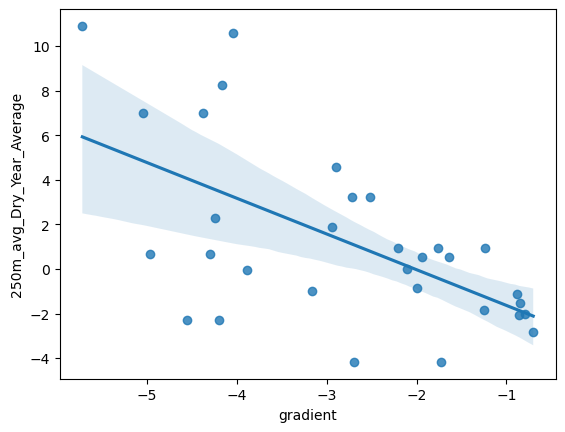

In [35]:
simple_5021['250m_avg_Dry_Year_Average'] = pd.to_numeric(simple_5021['250m_avg_Dry_Year_Average'], errors='coerce')
sns.regplot(data=simple_5021[simple_5021.p_slope < 0.01]
            , x="gradient", y="250m_avg_Dry_Year_Average")
print(f"Gradient against Dry_SAR for p_slope < 0.01")
plt.show()

In [60]:
simple_std = simple_5021.copy()
simple_std["gradient_z"] = (simple_std.gradient - simple_std.gradient.mean()) / simple_std.gradient.std()
simple_std["SAR_z"] = ((simple_std["250m_avg_Dry_Year_Average"] - sar_gdf["Dry_Year_Avg"].mean()) 
                       / sar_gdf["Dry_Year_Avg"].std())

In [69]:
sar_gdf

CODE  Dry_Year_Avg  Wet_Year_Avg        LAT         LON  \
0       DX5IPRM      0.283333         2.226  40.338973 -122.018572   
1       DX5IPRN     -1.985000         3.196  40.338973 -122.017438   
2       DX5IPRO     -2.105000         2.860  40.338973 -122.016305   
3       DX5IPRP     -1.195000         3.244  40.338973 -122.015171   
4       DX5IPRQ     -2.605000         3.740  40.338973 -122.014037   
...         ...           ...           ...        ...         ...   
707339  CQLMEFC     -6.140000           NaN  38.023736 -121.775985   
707340  CQLMEFD           NaN           NaN  38.023736 -121.774851   
707341  CQL0YTF     -3.815000        -0.812  38.022836 -121.781653   
707342  CQL0YTJ     -8.205000           NaN  38.022836 -121.777118   
707343  CQKFJ7K     -5.185000         1.910  38.021936 -121.785053   

                           geometry  
0       POINT (-122.01857 40.33897)  
1       POINT (-122.01744 40.33897)  
2        POINT (-122.0163 40.33897)  
3       POINT (-122.01517 40.33897)  
4       POINT (-122.01404 40.33897)  
...                             ...  
707339  POINT (-121.77598 38.02374)  
707340  POINT (-121.77485 38.02374)  
707341  POINT (-121.78165 38.02284)  
707342  POINT (-121.77712 38.02284)  
707343  POINT (-121.78505 38.02194)  

[707344 rows x 6 columns]

Gradient against Dry_SAR (z-score) for p_slope < 0.01


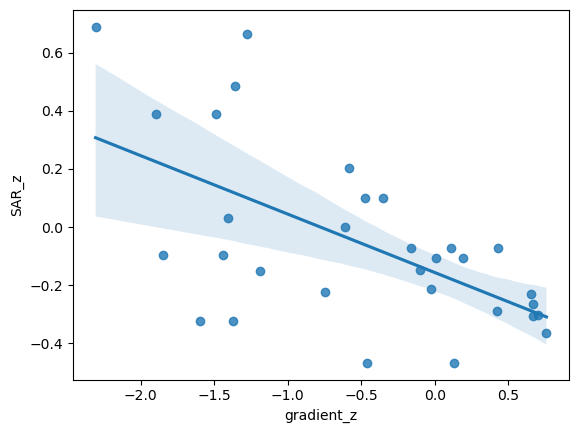

In [64]:
sns.regplot(data=simple_std[simple_std.p_slope < 0.01]
            , x="gradient_z", y="SAR_z")
print(f"Gradient against Dry_SAR (z-score) for p_slope < 0.01")
plt.show()

Gradient against Dry_SAR (z-score) for p_slope < 0.05


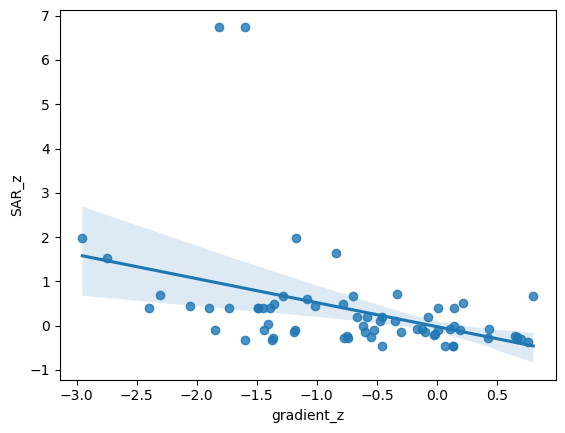

In [66]:
sns.regplot(data=simple_std[simple_std.p_slope < 0.05]
            , x="gradient_z", y="SAR_z")
print(f"Gradient against Dry_SAR (z-score) for p_slope < 0.05")
plt.show()

Gradient against Dry_SAR (z-score)


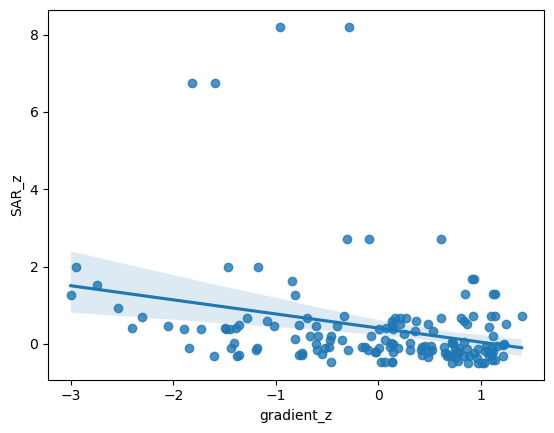

In [68]:
sns.regplot(data=simple_std
            , x="gradient_z", y="SAR_z")
print(f"Gradient against Dry_SAR (z-score)")
plt.show()

In [36]:
linregress(x=simple_5021[simple_5021.p_slope < 0.01].dropna().gradient, y=simple_5021[simple_5021.p_slope < 0.01].dropna()["250m_avg_Dry_Year_Average"])

LinregressResult(slope=-1.6031043993240945, intercept=-3.2411390421847655, rvalue=-0.5940481535961896, pvalue=0.0004260747454918732, stderr=0.40311516410605086, intercept_stderr=1.2666808137312904)

In [37]:
len(simple_5021[simple_5021.p_slope < 0.01].dropna())

31

In [38]:
temp = simple_5021[simple_5021.p_slope < 0.05].dropna()
len(temp)

68

In [39]:
linregress(x=temp.gradient, y=temp["250m_avg_Dry_Year_Average"])

LinregressResult(slope=-4.327460308292181, intercept=-6.793231388777, rvalue=-0.39011540846503107, pvalue=0.0010065823195839804, stderr=1.2572373674527644, intercept_stderr=4.284100750053478)

Gradient against Dry_SAR for p_slope < 0.05


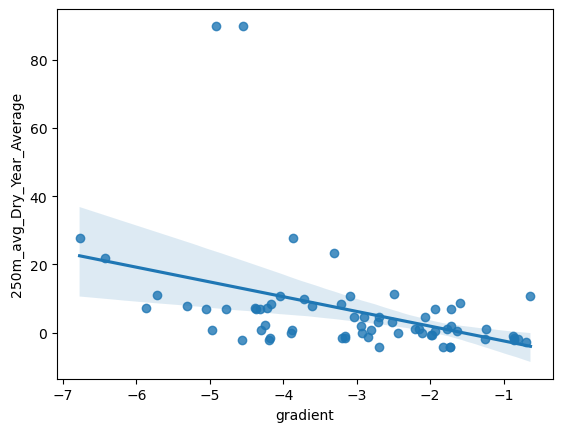

In [40]:
sns.regplot(data=temp, x=temp.gradient, y=temp["250m_avg_Dry_Year_Average"])
print(f"Gradient against Dry_SAR for p_slope < 0.05")
plt.show()

In [41]:
sig_df = simple_5021[simple_5021.p_slope < 0.05].dropna()
high_sig_df = simple_5021[simple_5021.p_slope < 0.01].dropna()

In [42]:
regular = linregress(y=simple_5021.dropna().gradient, x=simple_5021.dropna()["250m_avg_Dry_Year_Average"])
sig = linregress(y=sig_df.gradient, x=sig_df["250m_avg_Dry_Year_Average"])
high_sig = linregress(y=high_sig_df.gradient, x=high_sig_df["250m_avg_Dry_Year_Average"])

In [43]:
slopes  = np.array([regular.slope,  sig.slope,  high_sig.slope])
stderrs = np.array([regular.stderr, sig.stderr, high_sig.stderr])

In [44]:
weights = 1.0 / (stderrs ** 2)
combined_slope = np.sum(slopes * weights) / np.sum(weights)
combined_stderr = np.sqrt(1.0 / np.sum(weights))

In [45]:
combined_slope

-0.031885507866103203

In [46]:
abs(combined_slope) / combined_stderr

5.312974256599862

In [47]:
slope_interval = [combined_slope - 2 * combined_stderr, combined_slope + 2 * combined_stderr]
slope_interval

[-0.04388839224917527, -0.019882623483031138]

In [48]:
results = [regular, sig, high_sig]

In [49]:
intercepts = np.array([res.intercept for res in results])
intercepts_se = np.array([res.intercept_stderr for res in results])

weights_intercept = 1.0 / (intercepts_se ** 2)
combined_intercept = np.sum(weights_intercept * intercepts) / np.sum(weights_intercept)

combined_intercept_se = np.sqrt(1.0 / np.sum(weights_intercept))

In [50]:
combined_intercept

-2.264398082704085

In [51]:
combined_intercept_se

0.09926405753626869

#### Looking at setting up the model for 2021 as proof of concept before trying over more dry years.

In [52]:
simple_5021

site_code  latitude  longitude  well_depth  gradient   p_slope  \
0    388813N1217525W003  38.86903 -121.75250       573.0 -0.082527  0.419116   
1    386464N1216675W004  38.64640 -121.66750       545.0 -1.607192  0.103296   
2    388260N1215394W004  38.82388 -121.54310       120.0 -1.097408  0.063646   
3    388593N1214885W001  38.85930 -121.48850       700.0 -3.205201  0.018684   
4    388593N1214885W002  38.85930 -121.48850       500.0 -3.159497  0.015717   
..                  ...       ...        ...         ...       ...       ...   
164  390174N1214630W003  39.01744 -121.46299       450.0 -0.052759  0.732706   
165  390214N1214057W001  39.02142 -121.40566       175.0 -0.080143  0.798428   
166  390174N1214630W001  39.01744 -121.46299        71.0 -0.230286  0.680094   
167  390461N1214606W001  39.04606 -121.46065       285.0 -0.185076  0.744195   
168  391114N1215105W001  39.11138 -121.51047       105.0 -0.134373  0.817711   

     250m_avg_Dry_Year_Average  
0                    18.867778  
1                    10.572708  
2                    -0.008333  
3                    -1.676042  
4                    -1.676042  
..                         ...  
164                   1.340000  
165                  -3.514167  
166                   1.340000  
167                  -2.026615  
168                  -3.627308  

[169 rows x 7 columns]

In [53]:
simple_5021["grad_pred"] = simple_5021["250m_avg_Dry_Year_Average"] * combined_slope + combined_intercept
simple_5021["grad_pred_low"] = simple_5021["250m_avg_Dry_Year_Average"] * slope_interval[0] + combined_intercept
simple_5021["grad_pred_high"] = simple_5021["250m_avg_Dry_Year_Average"] * slope_interval[1] + combined_intercept

In [54]:
np.mean(abs(simple_5021.gradient - simple_5021.grad_pred))

1.4379950864243916

In [162]:
simple_5021_gdf = gpd.GeoDataFrame(
    simple_5021,
    geometry=gpd.points_from_xy(simple_5021.longitude, simple_5021.latitude),
    crs="EPSG:4326"
)

In [51]:
temp[temp["250m_avg_Dry_Year_Average"] > 40]

site_code  latitude  longitude  well_depth  gradient   p_slope  \
12  396244N1221872W001   39.6244  -122.1872      1020.0 -4.514329  0.010541   
30  396244N1221872W002   39.6244  -122.1872       720.0 -5.111193  0.015519   

    250m_avg_Dry_Year_Average  
12                  89.973333  
30                  89.973333

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


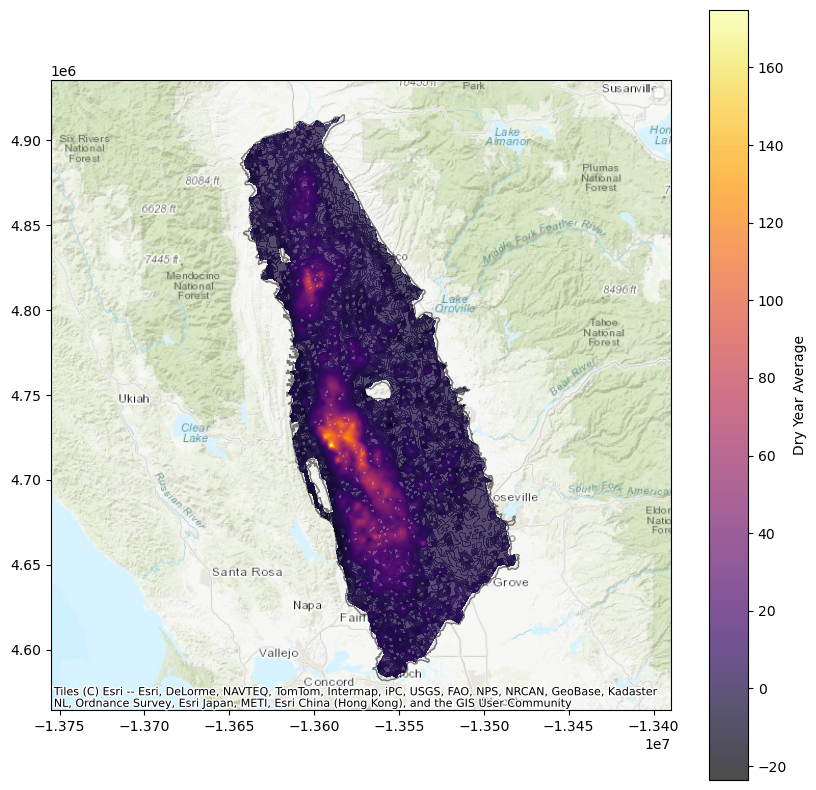

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked,
    levels=500,
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

ax.legend()
ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

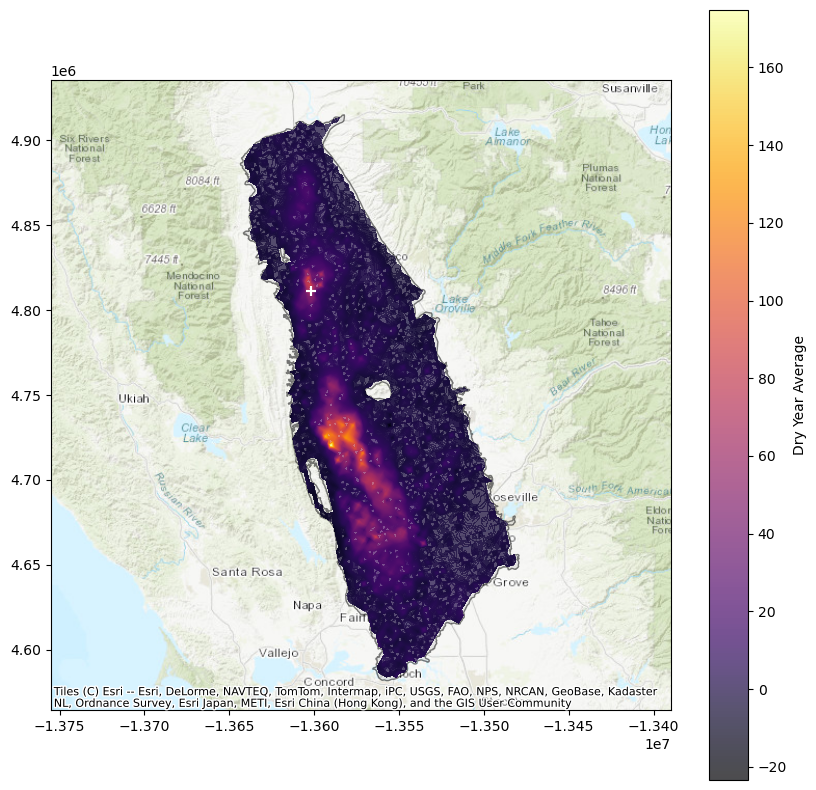

In [53]:
wells_df = temp[temp["250m_avg_Dry_Year_Average"] > 40].copy()

# Create a geometry column using longitude and latitude
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame, assuming the original coordinates are in EPSG:4326
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")

# Reproject wells to match the CRS of your larger_polygon_3857 (likely EPSG:3857)
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

# Create your plot as before
fig, ax = plt.subplots(figsize=(10, 10))

larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=1000, 
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

# Plot the wells as blue dots; adjust markersize as needed
wells_gdf.plot(
    ax=ax, 
    marker='+', 
    color='white', 
    markersize=50, 
    label='Wells'
)

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

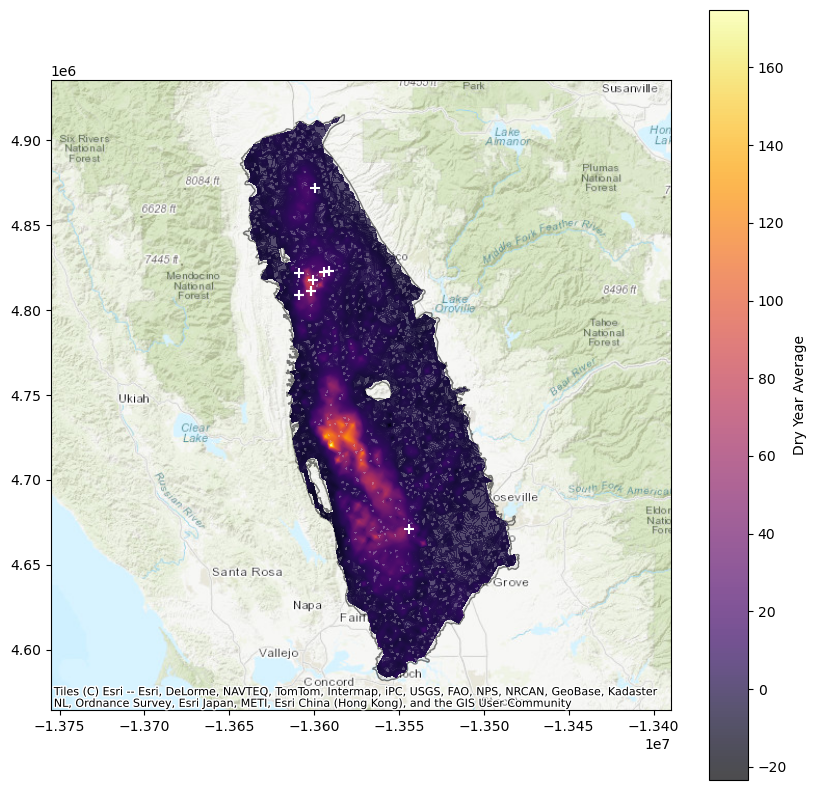

In [54]:
wells_df = temp[temp["250m_avg_Dry_Year_Average"] > 10].copy()

# Create a geometry column using longitude and latitude
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame, assuming the original coordinates are in EPSG:4326
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")

# Reproject wells to match the CRS of your larger_polygon_3857 (likely EPSG:3857)
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

# Create your plot as before
fig, ax = plt.subplots(figsize=(10, 10))

larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=1000, 
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

# Plot the wells as blue dots; adjust markersize as needed
wells_gdf.plot(
    ax=ax, 
    marker='+', 
    color='white', 
    markersize=50, 
    label='Wells'
)

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

well locations for p_slope < 0.05


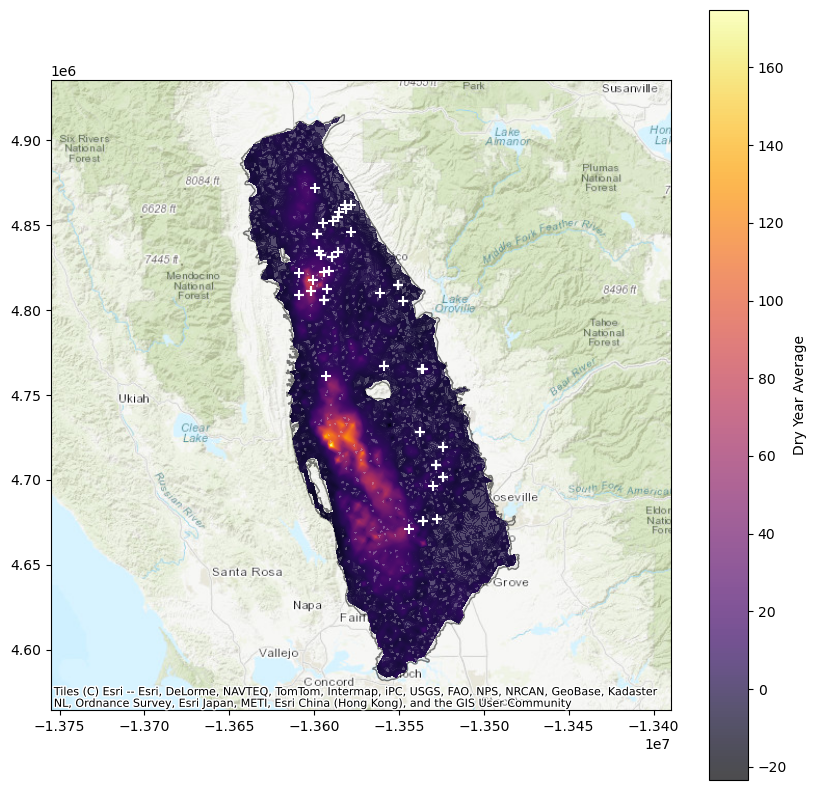

In [55]:
wells_df = temp

# Create a geometry column using longitude and latitude
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame, assuming the original coordinates are in EPSG:4326
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")

# Reproject wells to match the CRS of your larger_polygon_3857 (likely EPSG:3857)
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

# Create your plot as before
fig, ax = plt.subplots(figsize=(10, 10))

larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=1000, 
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

# Plot the wells as blue dots; adjust markersize as needed
wells_gdf.plot(
    ax=ax, 
    marker='+', 
    color='white', 
    markersize=50, 
    label='Wells'
)

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

print(f"well locations for p_slope < 0.05")
plt.show()

In [56]:
def get_cdl_value(year, lon, lat):
    """
    Fetches and parses the CDL value for a given year, lon, and lat coordinates.

    Args:
        year (int): The year of the data.
        lon (float): The longitude.
        lat (float): The latitude.

    Returns:
        dict: A dictionary containing the result data.
              Returns None if the request fails or the Result element is not found.
    """
    # Construct the URL with the provided year, x, and y
    transformer = Transformer.from_crs("epsg:4326", "epsg:5070", always_xy=True)
    x, y = transformer.transform(lon, lat)
    url = f"https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLValue?year={year}&x={x}&y={y}"

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the XML content
        root = ET.fromstring(response.content)

        # Extract the Result element
        result_element = root.find(".//Result")  # No namespace needed

        if result_element is not None:
            # Get the text content of the Result element
            result_string = result_element.text

            # Fix the dictionary format by adding quotes around keys
            # Replace single quotes with double quotes for JSON compatibility
            result_string = result_string.replace("{", "{\"").replace(":", "\":").replace(", ", ", \"")

            # Convert the fixed string to a dictionary using json.loads
            result_dict = json.loads(result_string)

            return result_dict
        else:
            print("Result element not found in the XML response.")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [57]:
temp_category = simple_5021.apply(
    lambda row: get_cdl_value(2020, row.longitude, row.latitude).get('category'), axis=1)
temp_colour = simple_5021.apply(
    lambda row: get_cdl_value(2020, row.longitude, row.latitude).get('color'), axis=1)

In [58]:
simple_5021["planted"] = temp_category
simple_5021["planted_col"] = temp_colour

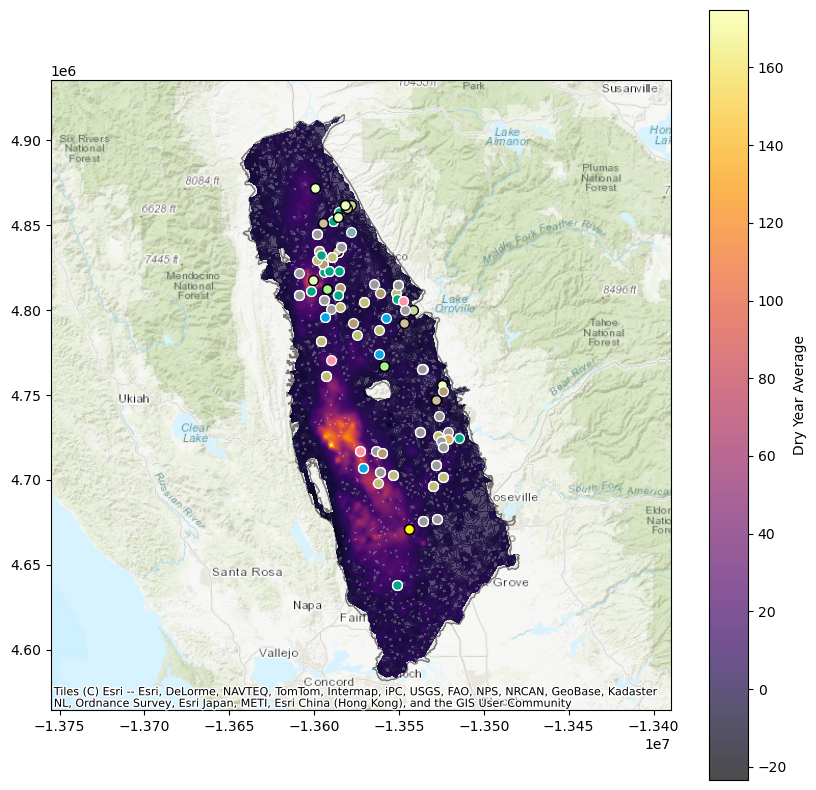

In [59]:
wells_df = simple_5021.copy()

# Create a geometry column using longitude and latitude
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame, assuming the original coordinates are in EPSG:4326
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")

# Reproject wells to match the CRS of your larger_polygon_3857 (likely EPSG:3857)
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot your base polygon
larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

# Plot the contour layer
contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=1000, 
    cmap='inferno', 
    alpha=0.7
)
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

# Function to determine the appropriate outline color based on the hex brightness
def get_outline_color(hex_color):
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    brightness = 0.299 * r + 0.587 * g + 0.114 * b
    # Adjust the threshold as necessary
    return 'black' if brightness > 186 else 'white'

# Loop over each well to plot a plus marker with a colored interior and black/white outline
for idx, row in wells_gdf.iterrows():
    hex_color = row['planted_col']
    outline_color = get_outline_color(hex_color)
    
    # Plot the outline (larger marker)
    ax.plot(
        row.geometry.x,
        row.geometry.y,
        marker='o',
        markersize=7,  # larger size for the outline
        color=outline_color,
        linestyle='None'
    )
    # Plot the colored marker (smaller marker)
    ax.plot(
        row.geometry.x,
        row.geometry.y,
        marker='o',
        markersize=5,
        color=hex_color,
        linestyle='None'
    )

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

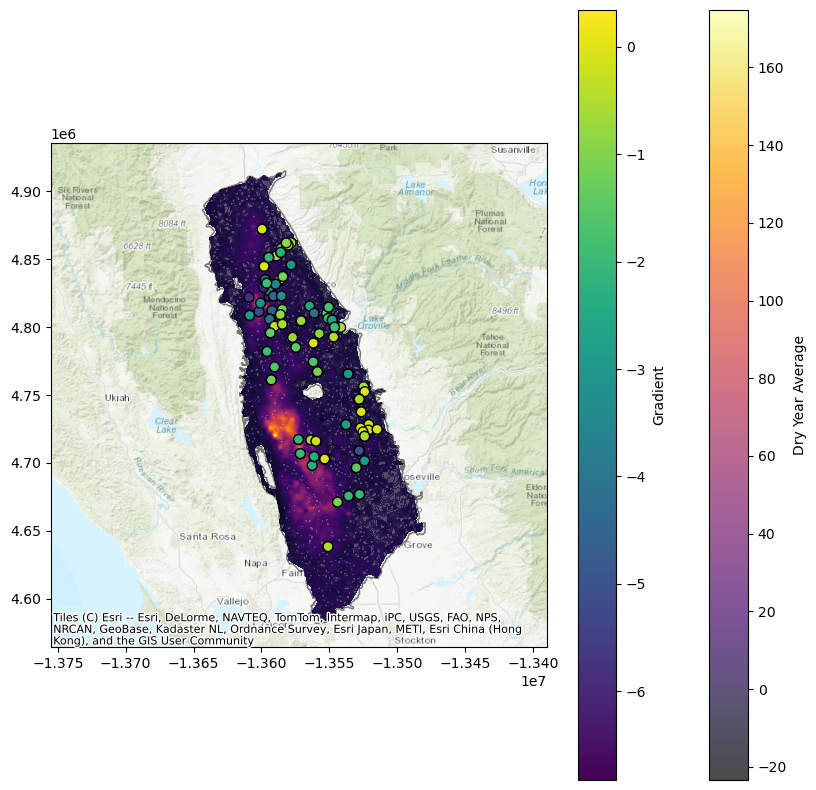

In [60]:
wells_df = simple_5021.copy()
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame (assuming EPSG:4326) and reproject to match the base polygon
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base polygon
larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot the contour layer
contour = ax.contourf(xx_3857, yy_3857, z_interp_masked, levels=1000, cmap='inferno', alpha=0.7)
cbar_contour = plt.colorbar(contour, ax=ax)
cbar_contour.set_label('Dry Year Average')

# Plot wells using a scatter plot colored by the "gradient" value.
# Adjust marker size (s) and edge color as desired.
sc = ax.scatter(
    wells_gdf.geometry.x,
    wells_gdf.geometry.y,
    c=wells_gdf['gradient'],
    cmap='viridis',   # Change colormap if needed
    s=50,             # Marker size
    edgecolor='black'
)

# Create a colorbar for the wells based on the gradient values
cbar_wells = plt.colorbar(sc, ax=ax)
cbar_wells.set_label('Gradient')

ax.set_aspect('equal')

# Add basemap
ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

In [61]:
finder = simple_5021[((simple_5021["250m_avg_Dry_Year_Average"] > 20)
                      & (simple_5021.gradient > -6)
                     & (simple_5021.latitude < 39))]

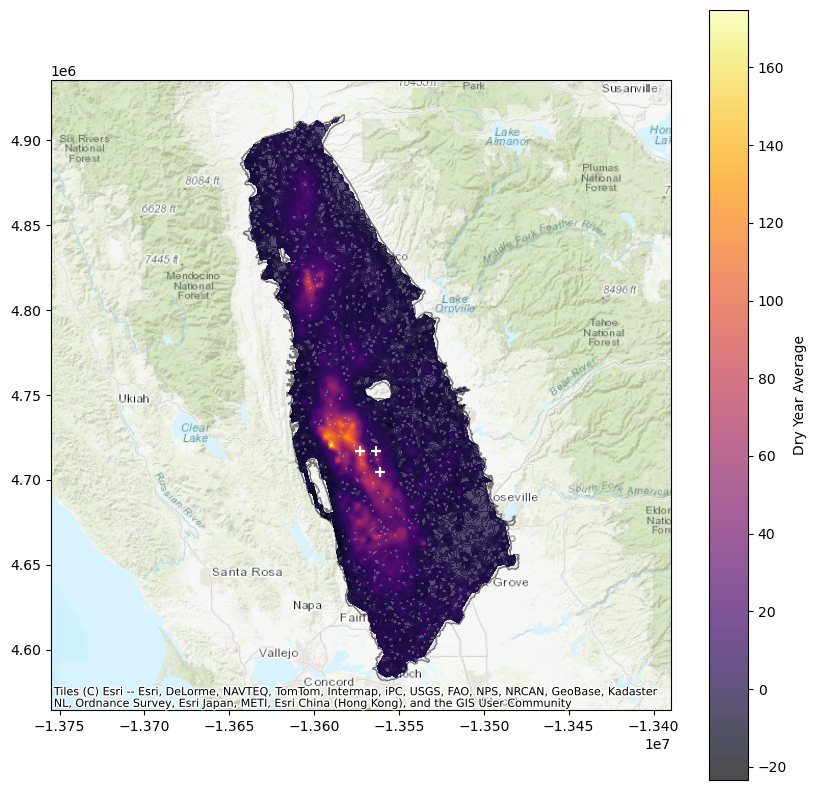

In [62]:
wells_df = finder.copy()

# Create a geometry column using longitude and latitude
wells_df['geometry'] = wells_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to a GeoDataFrame, assuming the original coordinates are in EPSG:4326
wells_gdf = gpd.GeoDataFrame(wells_df, geometry='geometry', crs="EPSG:4326")

# Reproject wells to match the CRS of your larger_polygon_3857 (likely EPSG:3857)
wells_gdf = wells_gdf.to_crs(larger_polygon_3857.crs)

# Create your plot as before
fig, ax = plt.subplots(figsize=(10, 10))

larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=1000, 
    cmap='inferno', 
    alpha=0.7
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Dry Year Average')

# Plot the wells as blue dots; adjust markersize as needed
wells_gdf.plot(
    ax=ax, 
    marker='+', 
    color='white', 
    markersize=50, 
    label='Wells'
)

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.Esri.WorldTopoMap
)

plt.show()

In [63]:
finder

site_code  latitude  longitude  well_depth  gradient   p_slope  \
112  389694N1219259W002  38.96940 -121.92590       480.0 -3.596639  0.070400   
120  388813N1218219W002  38.88130 -121.82190       250.0 -0.859515  0.153626   
124  388813N1218219W001  38.88130 -121.82190       545.0 -2.001293  0.130579   
129  388813N1218219W003  38.88130 -121.82190       380.0 -2.438003  0.083651   
138  389669N1218440W002  38.96688 -121.84391       525.0 -0.435412  0.567654   
140  389669N1218440W001  38.96688 -121.84391       709.0 -0.474693  0.640520   
141  389694N1219259W001  38.96940 -121.92590       885.0 -2.115618  0.099541   

     250m_avg_Dry_Year_Average                     planted planted_col  
112                 108.917500                       Plums     #FF91AB  
120                  37.221786     Developed/Low Intensity     #9C9C9C  
124                  37.221786     Developed/Low Intensity     #9C9C9C  
129                  37.221786     Developed/Low Intensity     #9C9C9C  
138                  23.748000  Developed/Medium Intensity     #9C9C9C  
140                  23.748000  Developed/Medium Intensity     #9C9C9C  
141                 108.917500                       Plums     #FF91AB

In [64]:
len(simple_5021)

169

In [66]:
a = simple_5021.copy()
a["Planted"] = ["Developed" if i.startswith("Developed") else i for i in a.planted]

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


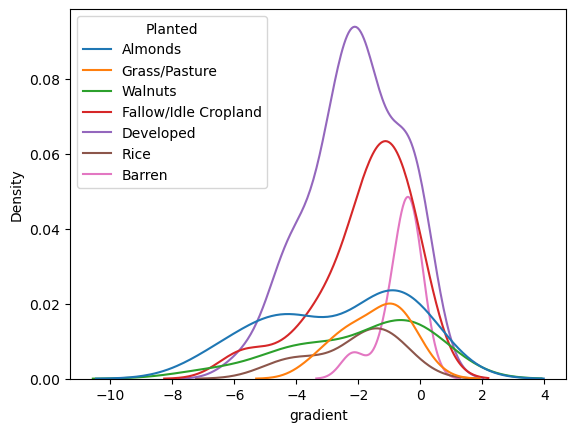

In [68]:
sns.kdeplot(data=a[a['Planted'].map(a['Planted'].value_counts()) >= 7], x='gradient', hue='Planted')
plt.show()

In [69]:
(a[a['Planted'].map(a['Planted'].value_counts()) >= 7]
 [["Planted", "gradient", "p_slope"]].groupby('Planted').mean())

gradient   p_slope
Planted                                 
Almonds              -2.657867  0.158788
Barren               -0.619834  0.278201
Developed            -2.094102  0.145763
Fallow/Idle Cropland -1.787080  0.185886
Grass/Pasture        -1.493409  0.164427
Rice                 -2.154645  0.097524
Walnuts              -2.041472  0.263492